In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms

In [2]:
NUM_CLASSES = 10

transform = transforms.Compose(
    [transforms.ToTensor()])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32,
                                          shuffle=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=32,
                                         shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [56]:
class Net(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.conv1 = nn.Conv2d(3, 10, kernel_size=(4, 4), stride=2)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=(3, 3), stride=2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(1280, 10)
        self.softmax = nn.Softmax()
    
    def forward(self, x):
        x = F.pad(self.conv1(x), (1, 0, 1, 0))
        x = F.pad(self.conv2(x), (1, 0, 1, 0))
        x = self.flatten(x)
        x = self.softmax(self.fc1(x))
        return x
model = Net()
model

Net(
  (conv1): Conv2d(3, 10, kernel_size=(4, 4), stride=(2, 2))
  (conv2): Conv2d(10, 20, kernel_size=(3, 3), stride=(2, 2))
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=1280, out_features=10, bias=True)
  (softmax): Softmax(dim=None)
)

In [57]:
class Net(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, stride=2)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1)
        self.conv4 = nn.Conv2d(64, 64, kernel_size=3, stride=2)

        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(64)
        self.leaky_relu = nn.LeakyReLU()

        self.fc_layer = nn.Sequential(
            nn.Flatten(),
            nn.Linear(4096, 128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(),
            nn.Dropout(),
            nn.Linear(128, 10),
            nn.Softmax()
        )
    
    def forward(self, x):
        x = F.pad(self.conv1(x), (1, 0, 1, 0))
        x = self.leaky_relu(self.bn1(x))
        x = F.pad(self.conv2(x), (1, 0, 1, 0))
        x = self.leaky_relu(self.bn1(x))

        x = F.pad(self.conv3(x), (1, 0, 1, 0))
        x = self.leaky_relu(self.bn2(x))

        x = F.pad(self.conv4(x), (1, 0, 1, 0))
        x = self.leaky_relu(self.bn2(x))


        x = self.fc_layer(x)
        return x
model = Net()
model

Net(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (leaky_relu): LeakyReLU(negative_slope=0.01)
  (fc_layer): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=4096, out_features=128, bias=True)
    (2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Dropout(p=0.5, inplace=False)
    (5): Linear(in_features=128, out_features=10, bias=True)
    (6): Softmax(dim=None)
  )
)

In [58]:
optimizer = optim.Adam(model.parameters(), lr=0.0005)
criterion = nn.CrossEntropyLoss()


In [59]:
for epoch in range(10):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

c:\Users\ggh5454\.conda\envs\pytorch_env1\lib\site-packages\torch\nn\modules\container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Finished Training


In [60]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = model(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 70 %


In [61]:
# prepare to count predictions for each class
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}


# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = model(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: plane is 75.4 %
Accuracy for class: car   is 83.5 %
Accuracy for class: bird  is 55.2 %
Accuracy for class: cat   is 54.6 %
Accuracy for class: deer  is 60.1 %
Accuracy for class: dog   is 58.1 %
Accuracy for class: frog  is 78.5 %
Accuracy for class: horse is 78.7 %
Accuracy for class: ship  is 80.4 %
Accuracy for class: truck is 80.2 %


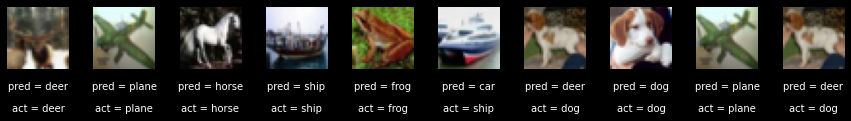

In [62]:
images, labels = next(iter(testloader))
with torch.no_grad():
    preds = model(images)

n_to_show = 10
indices = np.random.choice(range(len(images)), n_to_show)

fig = plt.figure(figsize=(15, 3))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i, idx in enumerate(indices):
    img = transforms.ToPILImage()(images[idx])
    ax = fig.add_subplot(1, n_to_show, i+1)
    ax.axis('off')
    ax.text(0.5, -0.35, 'pred = ' + classes[torch.argmax(preds[idx]).item()], fontsize=10, ha='center', transform=ax.transAxes) 
    ax.text(0.5, -0.7, 'act = ' + classes[labels[idx].item()], fontsize=10, ha='center', transform=ax.transAxes)
    ax.imshow(img)
